# Atividade 2 - Classificação Multiclasse

## Introdução

<font size=4.25>

<p style='text-align: justify;'>
Nesta atividade, foram explorados dois algoritmos de classificação: regressão e o k-vizinhos mais próximos. A fim de entendê-los mais detalhadamente, estes também foram elaborados do zero (<em>from scratch</em>) somente com o auxílio de bibliotecas primitivas, tais como <em> numpy </em>. Para tal, utilizou-se um conjunto de dados nos domínios do tempo e da frequência extraídos de sinais de acelorômetro e giroscópio de um <em> smartphone </em>. Os rótulos das amostras, conforme ilustra a Figura abaixo, indicam qual atividade realizada por um voluntário humano durante a aquisição dos sinais.    
<p/>
    
<p align="center">
<img src=rotulo-atividades.png>
<p/>
    
O desenvolvimento da atividade se dará nas seguintes etapas:
    
1) Análise dos Dados
    
    - Análise das features do problema
    - Classes do problema
    
<br>
    
2) Modelo de Regressão Logística
    
    - Modelagem Matemática
    - Matriz de Confusão
    - Métrica F1
    
<br>
    
3) Modelo k-vizinhos mais próximos - KNN
    
    - Modelagem Matemática
    - Matriz de Confusão
    - Métrica F1
 

## 1 - Análise dos Dados
<br>

<font size=4.25>

<p style='text-align: justify;'>
Os dados utilizados, provenientes do reposiório de dados da UCI, já encontravam-se separados nos conjunto de treinamento e testes. Desta forma, 7352 amostras foram destinadas ao treinamento do modelo e 2947 ao teste, cada é caracterizada por 561 atributos temporais ou espectrais.
    
Link para acesso aos dados: http://archive.ics.uci.edu/dataset/240/human+activity+recognition+using+smartphones  
<p/>

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import seaborn as sns
from scipy.stats import mode
import warnings
from numpy.linalg import norm

warnings.filterwarnings("ignore")

full_path = os.getcwd()+"/"

X_train=pd.read_fwf(full_path+"X_train.txt").to_numpy()
Y_train=pd.read_fwf(full_path+"y_train.txt").to_numpy()
X_test=pd.read_fwf(full_path+"X_test.txt").to_numpy()
Y_test=pd.read_fwf(full_path+"y_test.txt").to_numpy()

### 1.1 Analisando das features do problema


<font size=4.25>

<p style='text-align: justify;'>
Ao se observar os histogramas abaixos, em que foram plotadas as classes para as diferentes para algumas das <em> features </em> do problema, observa-se que os valores destas estão compreendidos entre -1 e 1, não necessitando portanto de nenhum tratamento neste sentido. Além disso, constata-se a partir de algumas features levantadas uma divisão clara entre as classes 0,1 e 2 das demais. Isto fundamenta-se no fato que, quando se observa a descrição dos rótulos associados a cada uma das atividades, estas classes estão atreladas às atividades que demandam algum movimento por parte do indivíduo.
<p/>

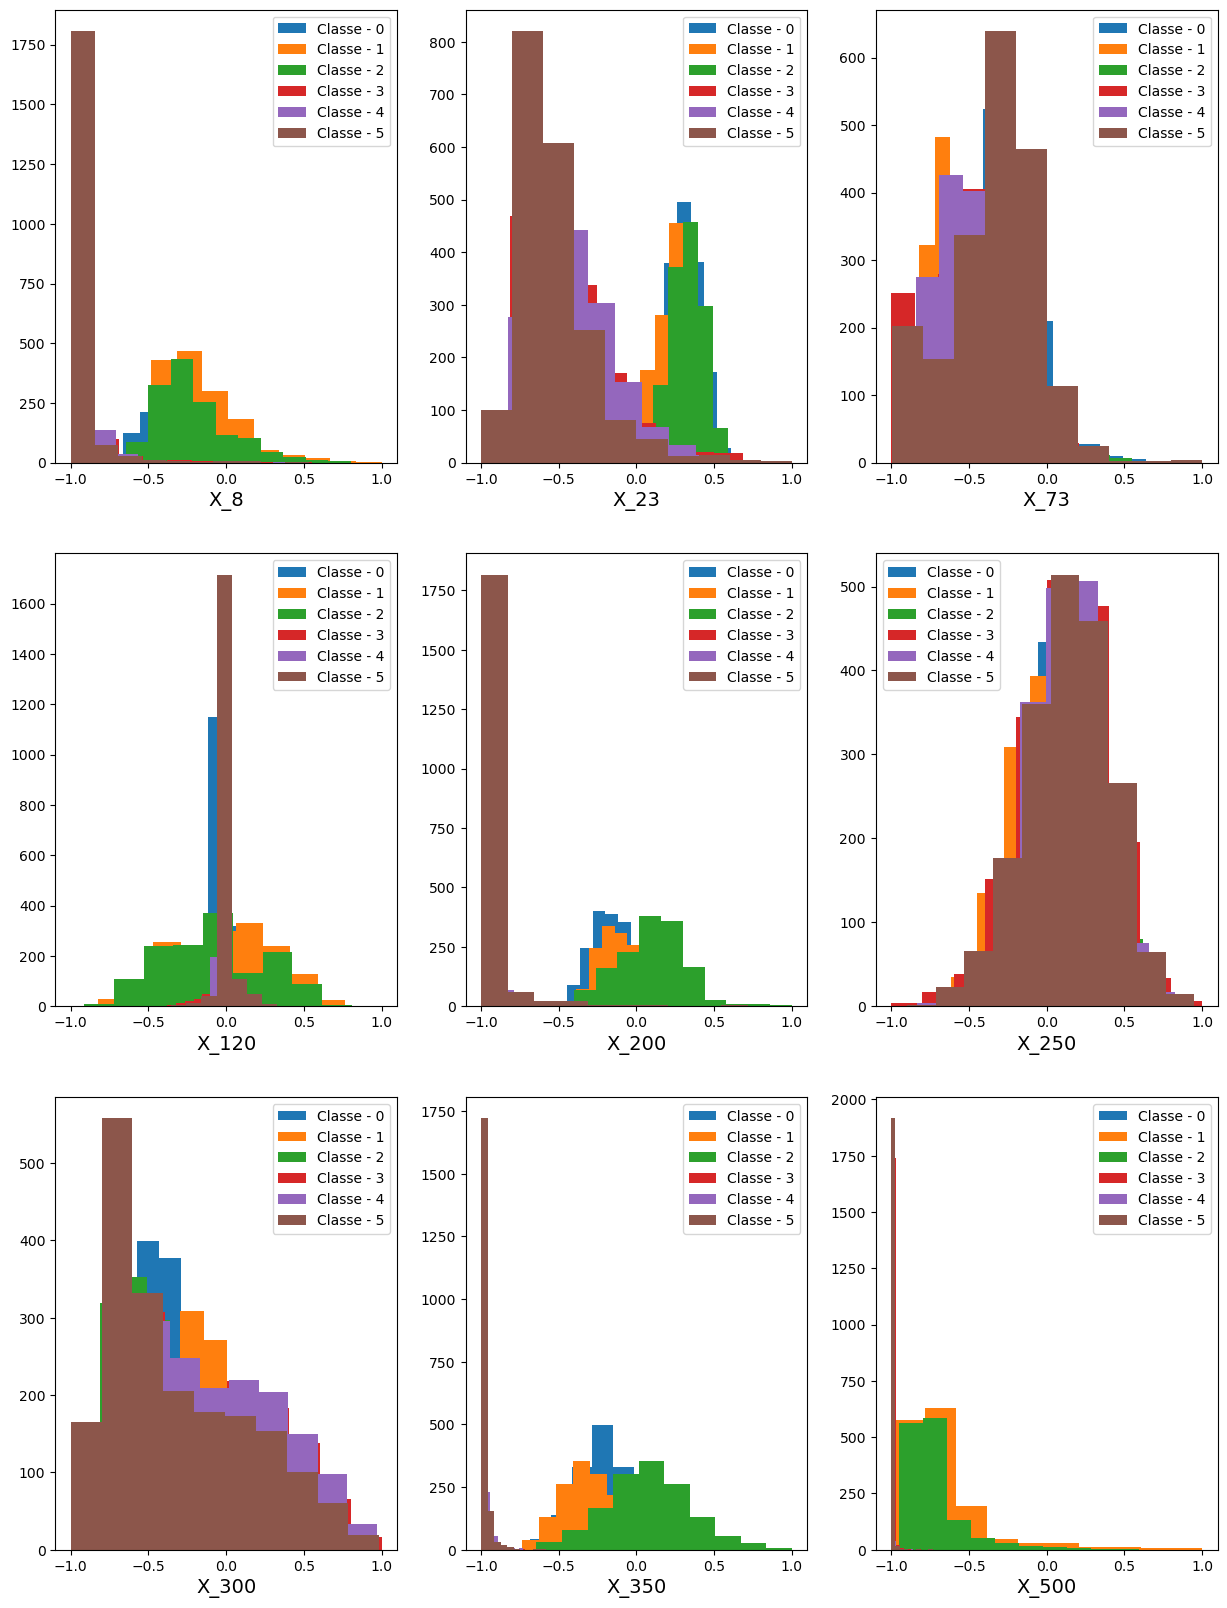

In [2]:
X_values = np.concatenate((X_train, X_test))

Y_values = np.concatenate((Y_train, Y_test))

features_list = [8,23,73,120,200,250,300,350,500]

figure, ax = plt.subplots(int(len(features_list)/3),3, figsize=(15,20))

for pos in range (len(features_list)):

    row, col = int(pos/3),pos%3  

    for values in np.unique(Y_values):

        class_features = np.where(Y_values==values)

        X_class_features = X_values[class_features[0]]

        ax[row, col].hist(X_class_features[:,features_list[pos]], label = f'Classe - {values-1}')
        
    ax[row,col].set_xlabel(f'X_{features_list[pos]}', fontsize=14)

    ax[row,col].legend()

### 1.2 Classes do Problema

<font size=4.25>

<p style='text-align: justify;'>
Outro ponto importante ao se analisar problemas de classificação diz respeito ao desbalanceamento de classes. Como o próprio nome sugere, o desblanceamento caracteriza-se por termos um número de amostras, referente a uma classe em específico, significativamente maior que as demais. Este problema faz com que os algoritmos de classificação adquiram uma visão enviesada do problema, favorecendo a classificação da classe majoritária do problema. Neste sentido, portanto, o modelo está sendo vitíma do famoso Paradoxo da Acurácia, onde pode-se ter altos valores de acurácia porém sem o devido discernimento da classe minoritária das demais. 
<p/>
  
<font size=4.25>

<p style='text-align: justify;'>
No problema em questão, observa-se através do gráfico abaixo, que o número de amostras por classe é parecido, não necessitando, portanto, nenhum tratamento em relação ao desbalanceamento de classes. 
<p/>
  

[Text(0, 6, '1722'),
 Text(0, 6, '1544'),
 Text(0, 6, '1406'),
 Text(0, 6, '1777'),
 Text(0, 6, '1904'),
 Text(0, 6, '1944')]

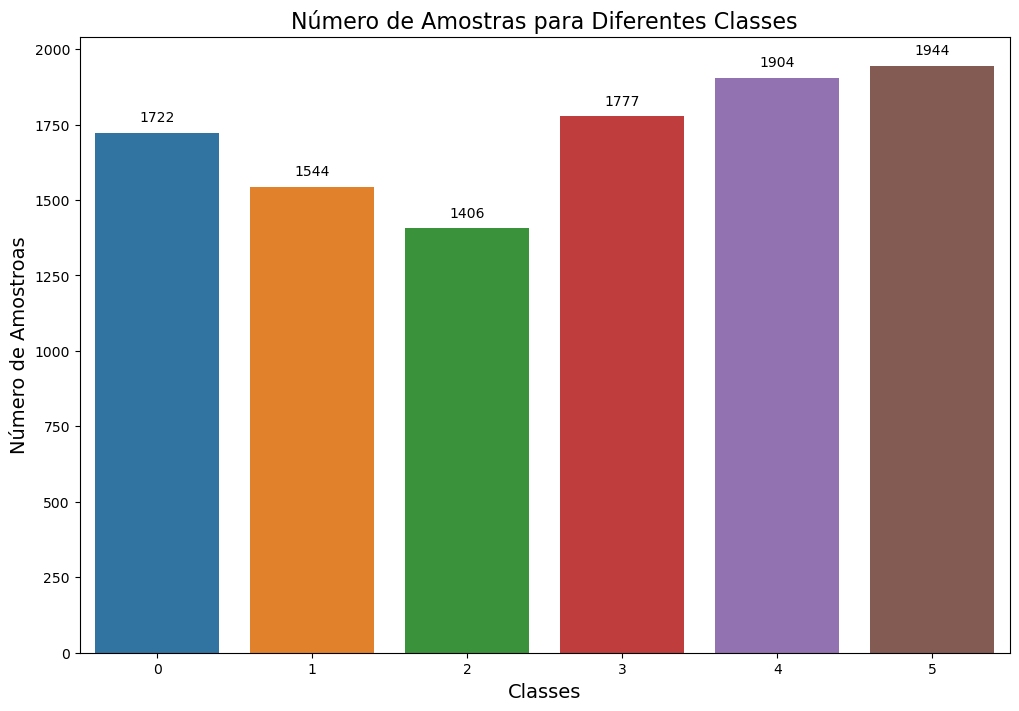

In [3]:
sample_count=[]

for values in np.unique(Y_values):
    
    class_features = np.where(Y_values==values)
    
    sample_count.append(len(class_features[0]))


fig, ax = plt.subplots(figsize=(12, 8))

barchart = sns.barplot(x=[i for i in range(len(sample_count))], y=sample_count, ax=ax)

plt.xlabel('Classes', fontsize=14)
plt.ylabel('Número de Amostroas', fontsize=14)
plt.title ('Número de Amostras para Diferentes Classes', fontsize=16)
barchart.bar_label(ax.containers[0], label_type='edge', padding=6)

## 2 - Modelo de Regressão Logística

### 2.1 - Modelagem Matemática

<br>

<font size=4.25>

<p style='text-align: justify;'>
O desenvolvimento do modelo de regresão logística baseou-se na função softmax (conforme apresenta a Equação 1). A partir desta função é possível aferir a probabilidade de ocorrência das diversas classes (Q) avaliadas. Desta forma, a cada amostra avaliada, a função <em> softmax </em> retorna um vetor de tamanho Q contendo a probabilidade de ocorrência de cada classe e a classe selecionada é aquela que apresenta a maior probabilidade. 
<p/>
       
\begin{equation} 
\hat{y}_{k}(x(i)) = \frac {exp^{Ф(x(i))^Tw_{k}}} {\sum_{j} exp^{Ф(x(i))^Tw_{k}}}
\end{equation}
    
onde: $w_{k}$ é o vetor de coeficientes associado à k-ésima saída e Ф ϵ $R^{N X K+1}$ refere-se à matriz dos dados de entrada de N amotras e K aributos por amostra.
       
$$ w_{k} =
\left [
\begin{matrix}
w_0^{(k)} & w_1^{(k)} & \cdots & w_K^{(k)}\\
\end{matrix}
\right ] 
$$

$$ Ф =
\left [
\begin{matrix}
Ф (x(0))^{T}\\
Ф (x(1))^{T}\\
\vdots \\
Ф (x(N-1))^{T} \\
\end{matrix}
\right ] 
$$

In [4]:
def softmax_output(X,w):
    z=np.exp(np.dot(X,w))
    
    z_sum = np.expand_dims(np.sum(z, axis=1), axis=0)
    Y_softmax=z/z_sum.T
    return Y_softmax

<font size=4.25>
<p style='text-align: justify;'>
A partir da modelagem proposta pela função <em> softmax </em>, a entropia cruzada $ J_{CE}(w)$ - função custo (Equação 2) - bem como a função gradiente (Equação 3) apresentam, respectivamente, as configurações a seguir: 
<p/>
 
\begin{equation} 
J_{CE}(w) = -\frac {1} {m}\sum_{i=0}^{N-1}\sum_{k=1}^{Q} y_{i,k} log(\hat{y}(x(i))
\end{equation}
    
\begin{equation} 
\frac{\partial J_{CE}(W)}{\partial w_{k}} =\nabla J_{CE}(w) =-\frac{1} {m} \sum_{i=0}^{N-1}(y_{i,k}-\hat{y}_{k}(x(i)))Ф(x(i))^T
\end{equation}

In [5]:
def gradient_and_costfunction (X,Y,w):
    Y_softmax=softmax_output(X,w)
    Y_converted = Y_conversion (X,Y)
    
    J_sum_classes=np.sum(Y_converted*np.log(Y_softmax),axis=1)
    
    J=-1/(X.shape[0])*np.sum(J_sum_classes)
    J_grad = (1/X.shape[0])*((np.dot(X.T,(Y_softmax-Y_converted))))
    
    return J,J_grad

def Y_conversion (X,Y):
    Y_converted = np.zeros([X.shape[0], len(np.unique(Y))])
    for i in range(len(Y_converted)):
        Y_converted[i,Y_train[i]-1]=1
    return Y_converted

<font size=4.25>

<b> Observações Importantes:</b> 

<p style='text-align: justify;'>  
 - Destaca-se que a matriz contendo os rótulos do conjunto de teste e treinamento, a fim de realizar as contabilizações necessárias para o cálculo da função custo e gradiente, foram convertidos para a representação <em> one-hot encoding </em> (função Y conversion).
<p/>
 
<p style='text-align: justify;'>  
- Da função custo ($J_{CE}$) nota-se que à medida em que a probabilidade associada à classe que uma determinada a amostra i pertence, aproxima-se de zero, o logaritmo daquela probabilidade aumenta, conforme pode ser observado na figura abaixo. Tal comportamento necessariamente fará com que a função custo aumente e, portanto, que as amostras observadas sejam erroneamente classificadas. 
<p/>

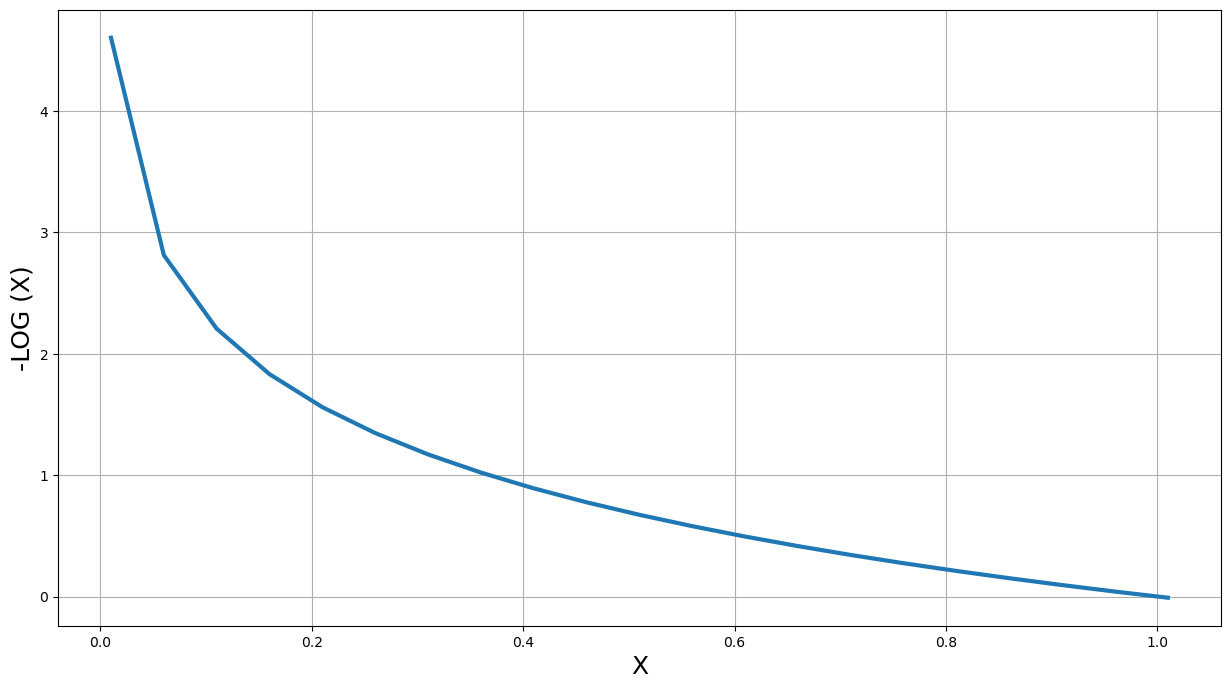

In [6]:
lista_x=[]
lista_y=[]

for i in np.arange(0.01, 1.05, 0.05):

    lista_x.append(i)
    lista_y.append(-np.log(i))

plt.figure(figsize=(15,8))
plt.plot(lista_x, lista_y, linewidth=3)
plt.xlabel('X', fontsize=18)
plt.ylabel('-LOG (X)', fontsize=18)
plt.grid()
plt.show()

<font size=4.25>

<p style='text-align: justify;'>
A função custo associada à entropria cruzada, é uma função convexa, isto é, através dessa propriedade, tem-se a garantia que a função quando atingir um mínimo local necessariamente atingirá um mínimo global. Contudo, diferentemente do problema de regressão linear para sistemas sobredeterminados, este é um tipo de problema que não possui solução fechada para os coeficientes w. Desta forma, é necessário lançar mão de algoritmos iterativos para realizar o treinamento do modelo. A regra de atualização (Equação 4) dos parâmetros w é apresentada na equação a seguir:
<p/>
    
     
\begin{equation} 
w_{i+1}\rightarrow w_{i} - \alpha \nabla J_{CE}(w_{i})^{T}
\end{equation}
    
onde $\alpha$ é equivalente à taxa de aprendizado.

<p style='text-align: justify;'>
Abaixo é apresentado o processo de atualização dos coeficientes de w. Ao todo, o processo iterativo compreendeu 2000 iterações a uma taxa de aprendizado equivalente a 0.15. Selecionou-se este número de iteração pois conforme pode ser observado na Figura abaixo, a entropria cruzada (função custo para o problema aprensentado) apresentava valores próximos a zero (≅ 0.06) ao final das 2000 iterações, indicando a convergência do processo. 
<p/>  

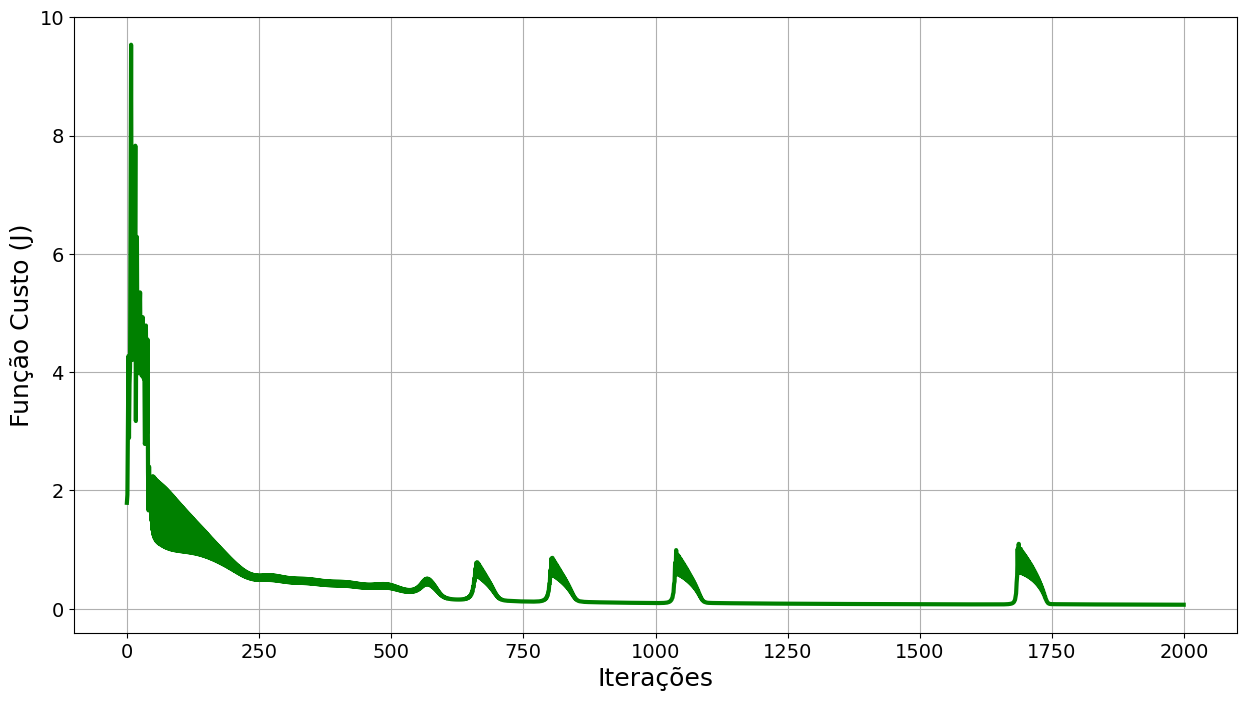

In [7]:
w=np.zeros([X_train.shape[1],len(np.unique(Y_train))])

it=0
it_max=2000

lista_J=[]


while it<it_max:
   
    J, J_grad=gradient_and_costfunction(X_train,Y_train,w)
    w=w-(0.15*(J_grad))
    
    lista_J.append(J)
    it+=1
    
fig_Jcost=plt.figure(figsize=(15,8))
plt.plot(lista_J, linewidth=3, color="green")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.xlabel("Iterações", fontsize=18)
plt.ylabel("Função Custo (J)",fontsize=18)
plt.show()

### 2.2 Matriz de Confusão - Modelo de Regressão Logística

<font size=4.25>

<p style='text-align: justify;'>
Após a determinação dos coeficientes w, referente aos 561 atributos temporais ou espectrais de cada amostra, avaliou-se o desempenho do modelo junto aos dados de teste. Para tal, como primeira forma de análise, foi levantada a matriz de confusão abaixo. Desta, nota-se que a partir dos quadros mais claros, que o classificador obtido conseguiu prever, em sua grande maioria, corretamente as classes avaliadas. 
<p/>

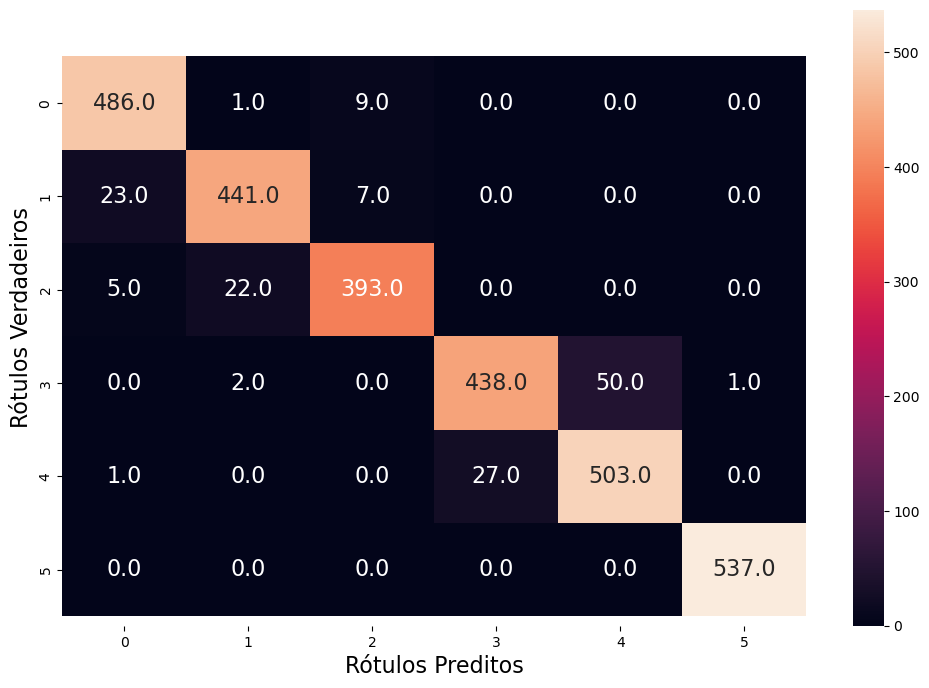

In [8]:
lista_classe=[]
Y_pred_test=softmax_output(X_test,w)
for i in range(len(Y_pred_test)):
    lista_classe.append((np.argmax(Y_pred_test[i]))+1)


fig1, ax = plt.subplots(figsize=(12, 8))
cf_matrix = confusion_matrix(Y_test,lista_classe)
cf_matrix_fig=sns.heatmap(cf_matrix, annot=True,annot_kws={"size": 16}, fmt='.1f', ax=ax)
ax.set_xlabel('Rótulos Preditos', fontsize=16);ax.set_ylabel('Rótulos Verdadeiros', fontsize=16);
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.1, top - 0.5)

plt.show()


### 2.3 Métrica $F_{1}$  - Modelo de Regressão Logística

<font size=4.25>

<p style='text-align: justify;'>
Para além da matriz de confusão, também foi levantada, como métrica de avaliação do modelo, a medida $F_{1}$ para cada classe individualmente. A medida $F_{1}$ pode ser interpretada como uma média harmônica, conforme demonstra a Equação 5, entre a precisão e a sensibilidade(<em>recall </em>). Dado que a $F_{1}$ Score trata-se de uma média harmônica, ela dará mais importância aos valores da métricas (precisão ou sensibilidade) que apresentarem valores mais baixos. Ao fazer isso, ela tenderá ao balanço entre as duas métricas citadas.
<p/>
    
\begin{equation} 
F_{1}=\frac{2*precisão*sensibilidade}{sensibilidade + precisão}
\end{equation}
    
<p style='text-align: justify;'>
Do gráfico abaixo, nota-se que os valores de $F_{1}$ obtidos são maiores que 0.93 para 5 das 6 classes avaliadas. Os valores mais diminutos de $F_{1}$ para classe 3 associa-se ao fato de que parte das amostras que pertencem à classe 3 (sentado) são classificadas como sendo da classe 4 (em pé) e vice-versa. Isto pode também pode ser visto na matriz de confusão previamente exposta. Muito provavelmente os dados extraídos tanto do acelerômetros quanto do giroscópio são semelhante para as classes 3 e 4, dificultando a classificação por parte do modelo. 
<p/>

[Text(0, 6, '0.9614'),
 Text(0, 6, '0.9413'),
 Text(0, 6, '0.9481'),
 Text(0, 6, '0.9163'),
 Text(0, 6, '0.928'),
 Text(0, 6, '0.9991')]

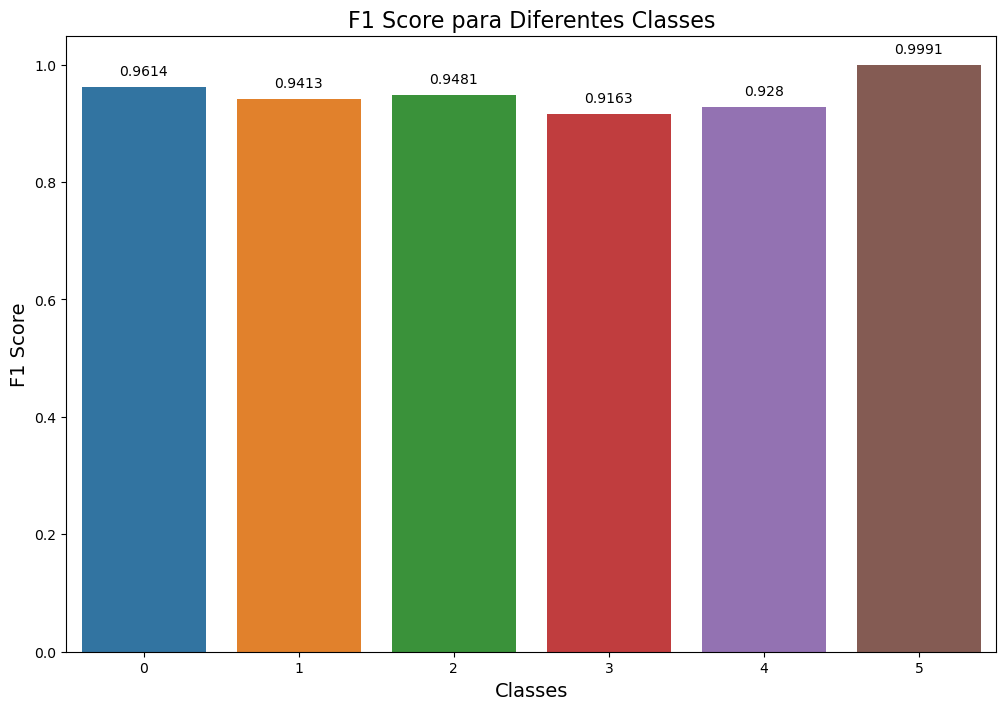

In [9]:
def F1_class (cf_matrix):
   
    lista_F1=[]
    
    lista_prec_sum=np.sum(cf_matrix, axis=0)
    lista_sens_sum=np.sum (cf_matrix, axis=1)
    
    for i in range(len(cf_matrix)):
        for j in range(len(cf_matrix[i])):
            if i==j:
                prec=cf_matrix[i][j]/lista_prec_sum[i]
                sens=cf_matrix[i][j]/lista_sens_sum[i]
                F1=(2*prec*sens)/(sens+prec)
                lista_F1.append(np.round(F1,4))
    return lista_F1


lista_F1 = F1_class(cf_matrix)

fig, ax = plt.subplots(figsize=(12, 8))
barchart = sns.barplot(x=[i for i in range(len(lista_F1))], y=lista_F1, ax=ax)

plt.xlabel('Classes', fontsize=14)
plt.ylabel('F1 Score', fontsize=14)
plt.title ('F1 Score para Diferentes Classes', fontsize=16)
barchart.bar_label(ax.containers[0], label_type='edge', padding=6)

<font size=4.25>

<p style='text-align: justify;'>
Adicionalmente, a fim de levantar o desempenho médio do classificador, levantou-se a medida $F_{1}$ globalmente. Esta foi feita de dois modos: 
<p/>
    
  
-**$F_{1}$** **micro**: Levando em conta todos os verdadeiros positivos, falsos positivos e negativos da matriz 
    
-$F_{1}$ **macro**: Média artimética das medidas de $F_{1}$ para as diferentes classes avaliadas.

<p style='text-align: justify;'>  
Conforme apresenta a Figura abaixo, o $F_{1}$ Micro e Macro apresentaram, respectivamente, valores equivalentes a 0.9501 e 0.9494, indicando, portanto, o bom desempenho do classificador na separação das classes. 
<p/>

[Text(0, 6, '0.9498'), Text(0, 6, '0.949')]

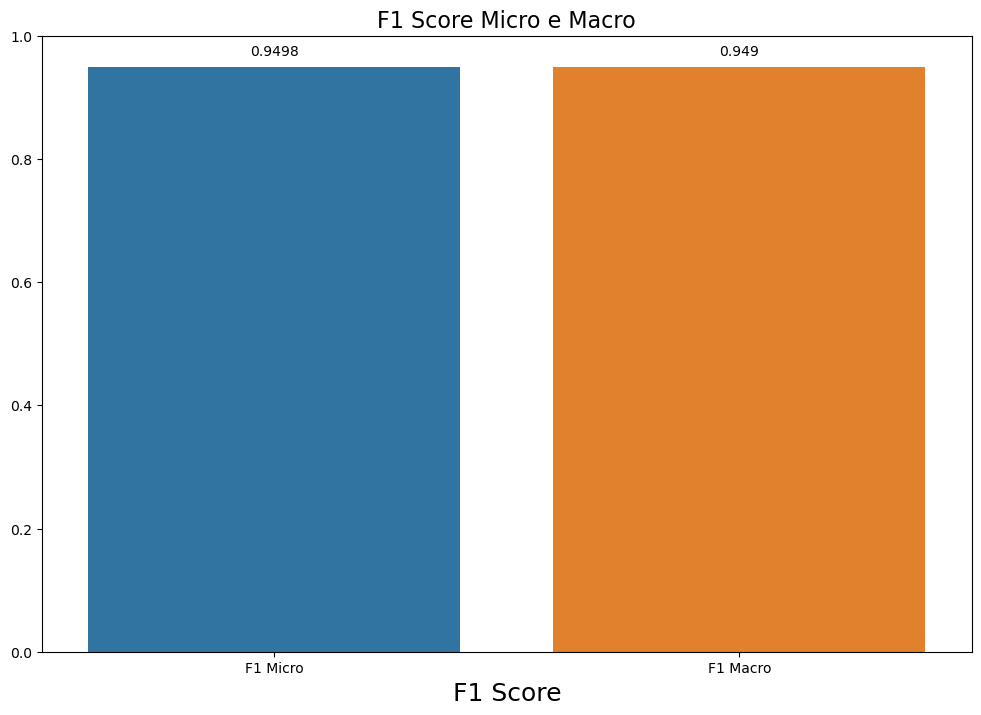

In [10]:
f1_score_micro = np.round(f1_score(Y_test,lista_classe, average='micro'),4)

lista_F1_final = [f1_score_micro, np.round(np.mean(np.array(lista_F1)),4)]

fig, ax = plt.subplots(figsize=(12, 8))
barchart = sns.barplot(x=['F1 Micro', 'F1 Macro'], y=lista_F1_final, ax=ax)

plt.xlabel('F1 Score', fontsize=18)
plt.title ('F1 Score Micro e Macro', fontsize=16)
plt.yticks([i for i in np.arange(0,1.2,0.2)])
barchart.bar_label(ax.containers[0], label_type='edge', padding=6)

## 3 - Modelo K vizinhos mais próximos - KNN

### 3.1 Modelagem Matemática

<br>

<font size=4.25>

<p style='text-align: justify;'>
A modelagem do tipo KNN é do tipo não paramétrica e, portanto, não há um modelo a ser ajustado tampouco é necessário fazer alguma suposição dos dados de entrada. 
<p/>

<p style='text-align: justify;'>  
De um modo geral, o KNN necessita do armazenamento dos dados de entrada x(i) em conjunto com as suas respectivas saídas y(i), i = 1, ..., N-1. Portanto, para uma nova padrão de entrada x', a saída gerada é aquela que está associada aos k padrões de treinamento que estão mais próximas à entrada x' no espaço de atributos. Desta forma, para atribuir o valor de saída relativos à entrada x', para problemas de regressão, é usualmente utilizado a média das saídas associadas aos k atributos mais próximos de x'. Enquanto que para problemas de classificação, a, saída atribuída ao novo padrão x' é produto do voto majoritário (moda) dos k vizinhos mais próximos. Assim sendo, para o problema em questão, tem-se a necessidade de definir as seguintes variáveis:
<p/>
    
1) **Métrica de distância no espaço de atributos**: Para este caso, foi utilizado a norma euclidiana (Equação 6).
    
\begin{equation} 
d(x;y) =\sqrt{\sum_{i=1}^{K}|x_{i}-y_{i}|^{2}}
\end{equation}
    
2) **Valor do parâmetro k**: Para este problema, foram avaliados 1,3,5,10,20,30,50,75,100 e 150 vizinhos mais próximos. 
        



In [11]:
full_path = os.getcwd()+"/"

X_train=pd.read_fwf(full_path+"X_train.txt").to_numpy()
Y_train=pd.read_fwf(full_path+"y_train.txt").to_numpy()
X_test=pd.read_fwf(full_path+"X_test.txt").to_numpy()
Y_test=pd.read_fwf(full_path+"y_test.txt").to_numpy()

def KNN (X_treinamento, Y_treinamento, X_deduction,k):
    
    dist = X_treinamento - X_deduction
    norm_ecl = np.expand_dims(norm(dist, axis=1),axis=1)
   
    X_and_dist=np.concatenate((X_treinamento,Y_treinamento), axis=1)

    X_and_dist=np.concatenate((X_and_dist,norm_ecl), axis=1)
    
    X_and_distance_ordered = X_and_dist[X_and_dist[:, X_and_dist.shape[1]-1].argsort()]
    
    X_KNN = X_and_distance_ordered[0:k ,:]
   
    y_KNN = X_KNN[:, X_KNN.shape[1]-2]
    
    return mode(y_KNN)[0]

K_values = [1,3,5,10,20,30,50,75,100,150]
Y_pred = np.zeros((X_test.shape[0],len(K_values)))
contador=0

for k in K_values:
    print(k)
    for i in range(X_test.shape[0]):
        Y_pred[i, contador]= KNN(X_train,Y_train, X_test[i,:],k)
    contador+=1


1
3
5
10
20
30
50
75
100
150


### 3.2 Matriz de Confusão - Modelo k vizinhos mais próximos (KNN)


<br>

<font size=4.25>

<p style='text-align: justify;'>
A partir das matrizes de confusão abaixo nota-se que a abordagem KNN corrobora com a dificuldade de distinção por parte do classificador entre as classes 3 e 4. Observando os resultados obtidos por ambas as abordagens para o problema de classificação multi-classe, nota-se que, embora a abordagem KNN seja um modo mais simples de classificação, ela traz consigo erros mais significativos para problemas de classificação desta complexidade. Constata-se que classes (0-Caminhada, 1- Subindo Escadas, 2-Descendo Escadas, por exemplo) de fácil classificação pelo modelo de regressão logística, não são tão facilmente classificáveis quando se utiliza a abordagem KNN. Além disso, erros referentes à classificação das classes 3 e 4 apresentados pelo modelo de regressão logística, tornam-se ainda maiores quando a abordagem KNN é utilizada. Por outro lado, a partir das matrizes de confusão, observa-se que a classificação da classe 5 por ambas as abordagens avaliadas é altamente acurada, provando o alto grau de correlação entre os atributos de entrada e saída.
<p/>



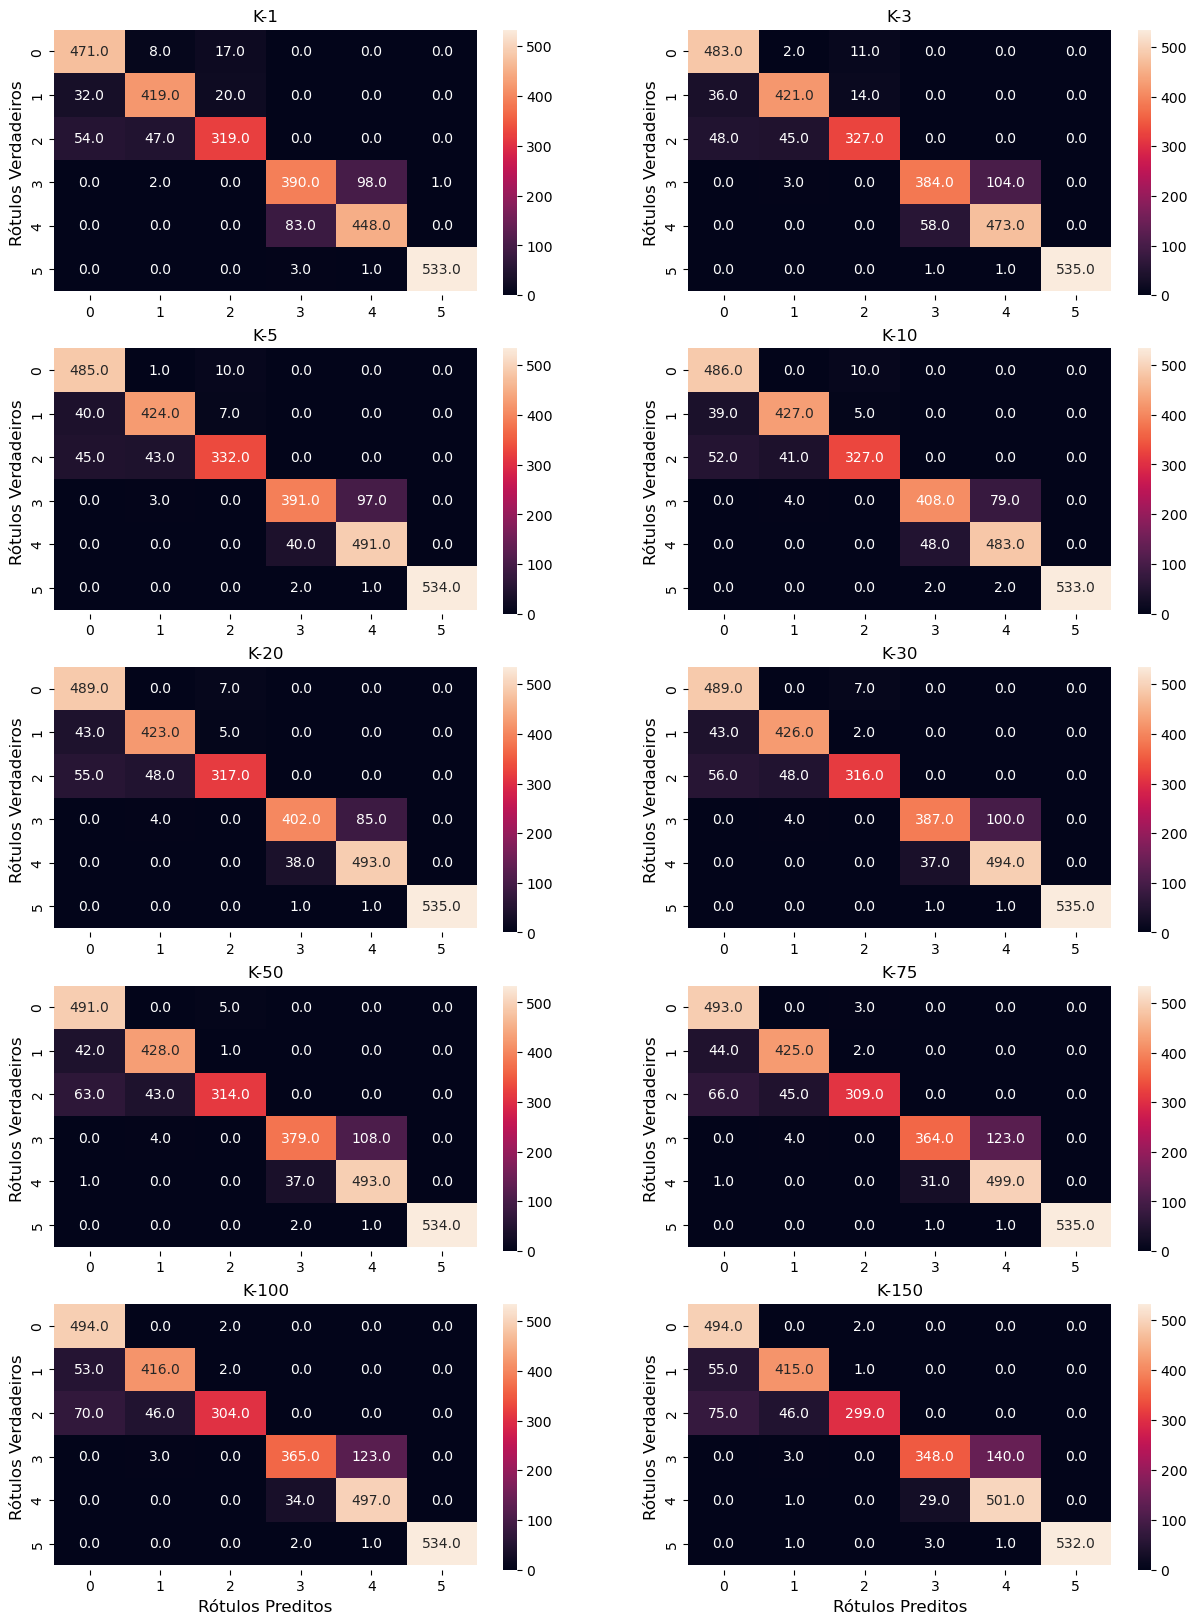

In [12]:
figure, ax = plt.subplots(int(len(K_values)/2),2, figsize=(15,20))


for i in range(len(K_values)): 
    
    if i%2 ==1:
        
        row, col = int((i-1)/2), 1
        
    else:
        
        row, col = int(i/2),0
    
    
    cf_matrix= confusion_matrix(Y_test, Y_pred[:,i])
    cf_matrix_fig=sns.heatmap(cf_matrix, annot=True,annot_kws={"size": 10}, fmt='.1f', ax=ax[row,col])
    ax[row,col].set_ylabel('Rótulos Verdadeiros', fontsize=12);
    
    
    if i == len(K_values)-1 or i == len(K_values)-2:  
    
        ax[row,col].set_xlabel('Rótulos Preditos', fontsize=12);
    
    bottom, top = ax[row,col].get_ylim()
    ax[row,col].set_title (f'K-{K_values[i]}', fontsize=12)
    ax[row,col].set_ylim(bottom + 0.1, top)    

### 3.3 Métrica $F_{1}$ - Modelo k vizinhos mais próximos (KNN)


<br>

<font size=4.25>

<p style='text-align: justify;'>
Quando observa-se o $F_{1}$ levantados por classes e para cada um dos valores de k avaliados,constata-se que os valores de $F_{1}$ mais diminutos associados às classes 2, 3 e 4. Estas constatações corroboram com o que foi observado durante a análise das matrizes de confusão, isto é: ao se utilizar o modelo KNN, a classe 2, por exemplo, apresenta maior dificuldades em ser classificada quando comparado ao modelo de regressão logística. Além disso, as dificuldades para a classificação das classes 3 e 4 já apresentadas pelo modelo regressão logística, intensificam-se ao se utilizar o modelo KNN. 
<p/>

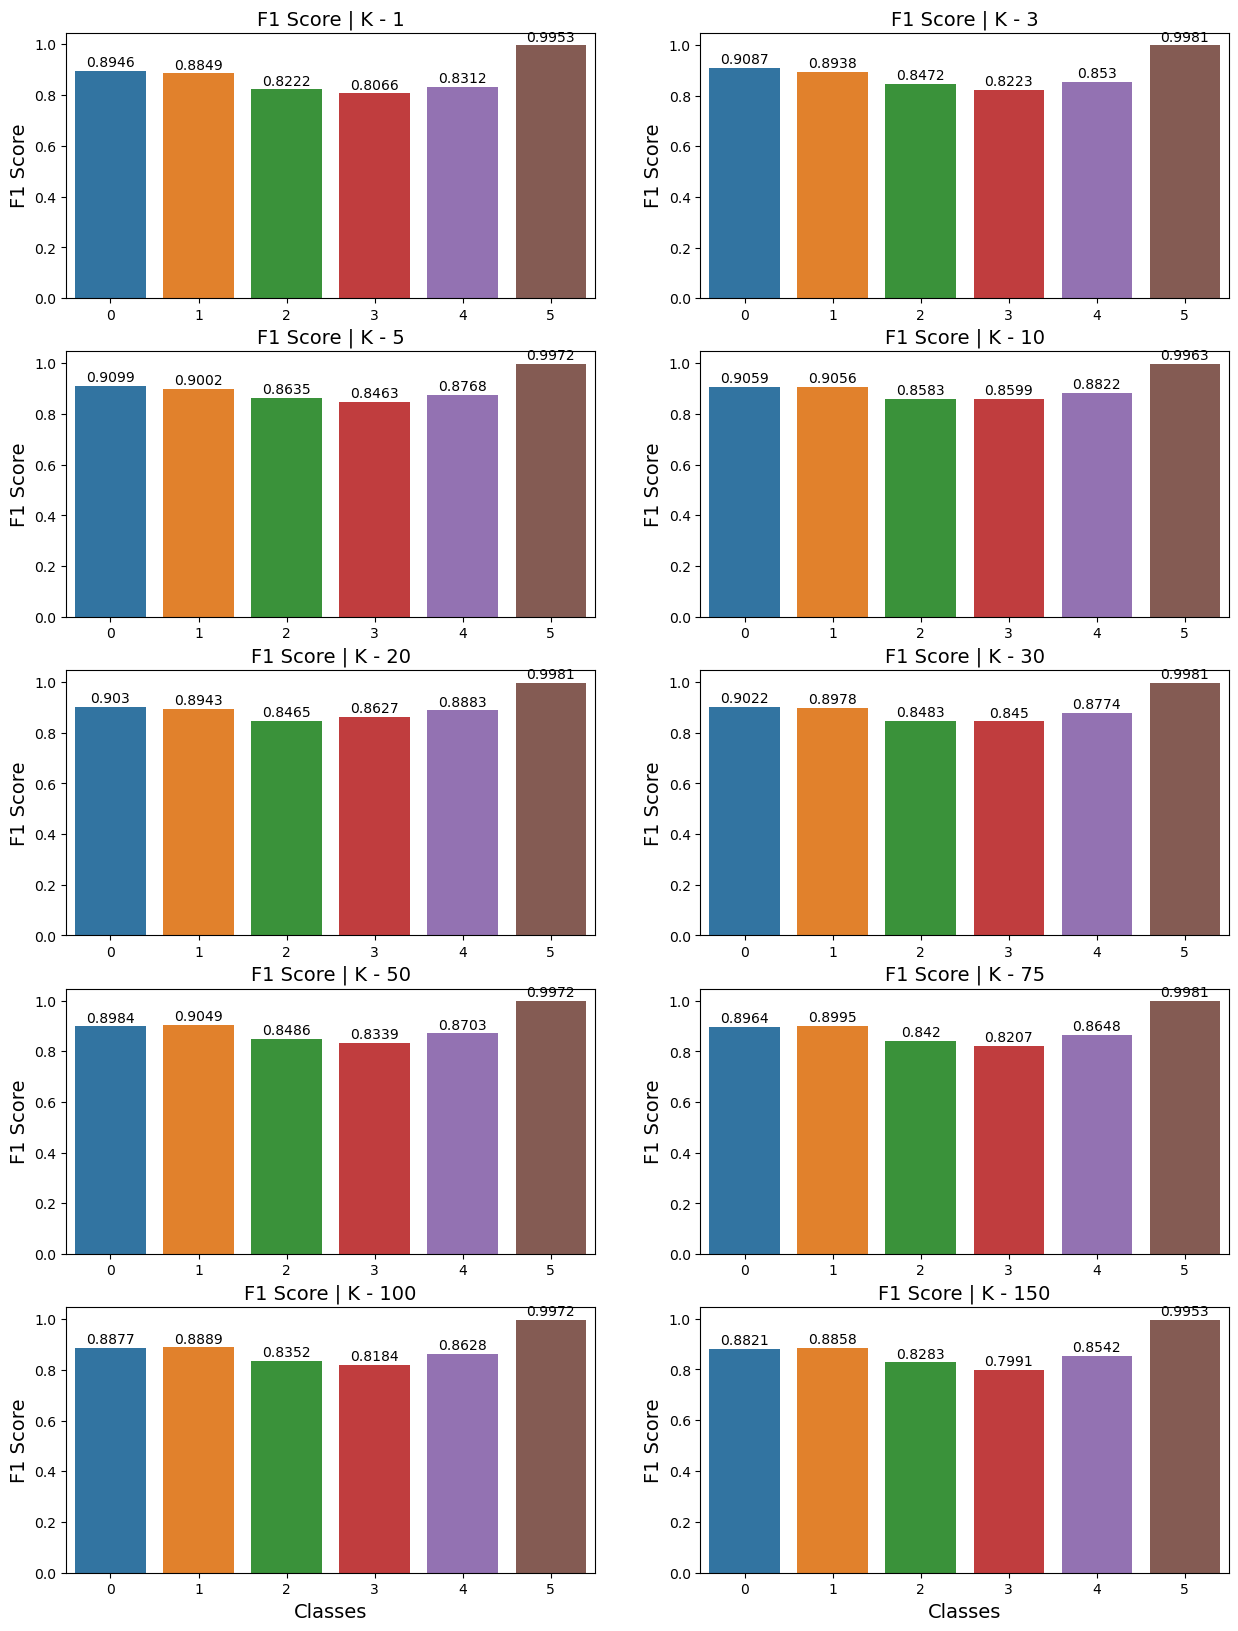

In [13]:
figure, ax = plt.subplots(int(len(K_values)/2),2, figsize=(15,20))

for i in range(len(K_values)): 
    
    if i%2 ==1:
        
        row, col = int((i-1)/2), 1
        
    else:
        
        row, col = int(i/2),0
    
    
 
    if i == len(K_values)-1 or i == len(K_values)-2:  
    
        ax[row,col].set_xlabel('Classes', fontsize=14);
    
    cf_matrix= confusion_matrix(Y_test, Y_pred[:,i])
    lista_F1 = F1_class(cf_matrix)

    barchart = sns.barplot(x=[i for i in range(len(lista_F1))], y=lista_F1, ax=ax[row, col])

    ax[row,col].set_ylabel('F1 Score', fontsize=14)
    title = f'F1 Score | K - {K_values[i]}'
    ax[row, col].set_title(title, fontsize=14)
    barchart.bar_label(ax[row,col].containers[0], label_type='edge', padding=1)


<font size=4.25>

<p style='text-align: justify;'>
Semelhantemente ao modelo de regressão logística, levantou-se a medida $F_{1}$ globalmente, através do $F_{1}$ micro e do $F_{1}$ macro. O cálculo do primeiro leva em conta todos os verdadeiros positivos, falsos positivos e negativos levantado em cada uma das classes. Enquanto que o segundo é uma média aritmética dos valores de F1 levantados para cada uma das classes. Conforme apresenta o gráfico abaixo, o valor de K que apresentou os valores mais significativos para ambos, F1 micro e macro, foi equivalente a 10. 
<p/>
 
<p style='text-align: justify;'>
Interessantemente, através dos mesmos gráficos, é possível observar que  os valores de F1 macro e micro, à medida que se varia os valores de K, apresentam uma espécie de perfil parabólico. Isto essencialmente deve-se ao fato de que quando se escolhe valores de K menores, tais como 1,3 e 5, o modelo de KNN tenderá a um sobreajuste (<em>overfitting</em>). Isto é possível observar nas figuras levantadas abaixo, onde o nível de região isoladas, em função da presença de poucas amostras de uma determinada classe, tende a ser bem significativo. Por outro lado, quando os valores de K são maiores, o KNN tende a apresentar um subajuste (<em>underfitting</em>). Quando se considera valores de K mais significativos (olhar Figura abaixo),há uma maior suavização das fronteiras compreendidas para cada uma das classes e, portanto, regiões dentro do domínio que exijam uma maior complexidade de classificação por parte do modelo são negligenciadas, ocasionando erros mais significativos. 
<p/>

([<matplotlib.axis.XTick at 0x7f7dff50dd10>,
 [Text(1, 0, '1'),
  Text(3, 0, '3'),
  Text(5, 0, '5'),
  Text(10, 0, '10'),
  Text(20, 0, '20'),
  Text(30, 0, '30'),
  Text(50, 0, '50'),
  Text(75, 0, '75'),
  Text(100, 0, '100'),
  Text(150, 0, '150')])

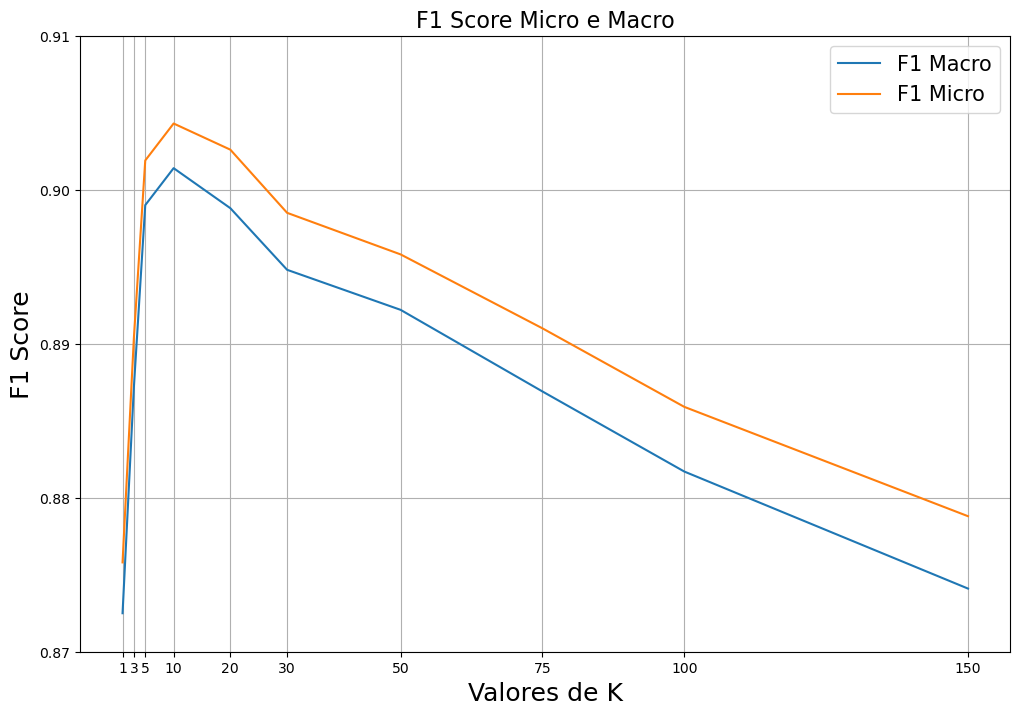

In [14]:
F1_micro_values =[]

F1_macro_values =[]

for i in range(len(K_values)): 

    cf_matrix= confusion_matrix(Y_test, Y_pred[:,i])
    
    F1_macro_values.append(np.round(np.mean(np.array(F1_class(cf_matrix))),4))
    
    F1_micro_values.append(np.round(f1_score(Y_test,Y_pred[:,i], average='micro'),4))
    
    
fig, ax = plt.subplots(figsize=(12, 8))

plt.plot(K_values, F1_macro_values, label = 'F1 Macro')
plt.plot(K_values, F1_micro_values, label = 'F1 Micro')

plt.xlabel('Valores de K', fontsize=18)
plt.ylabel('F1 Score', fontsize=18)
plt.title ('F1 Score Micro e Macro', fontsize=16)
plt.legend(fontsize=15)
plt.grid()
plt.yticks([i for i in np.arange(0.87,0.91,0.01)])
plt.xticks(K_values)

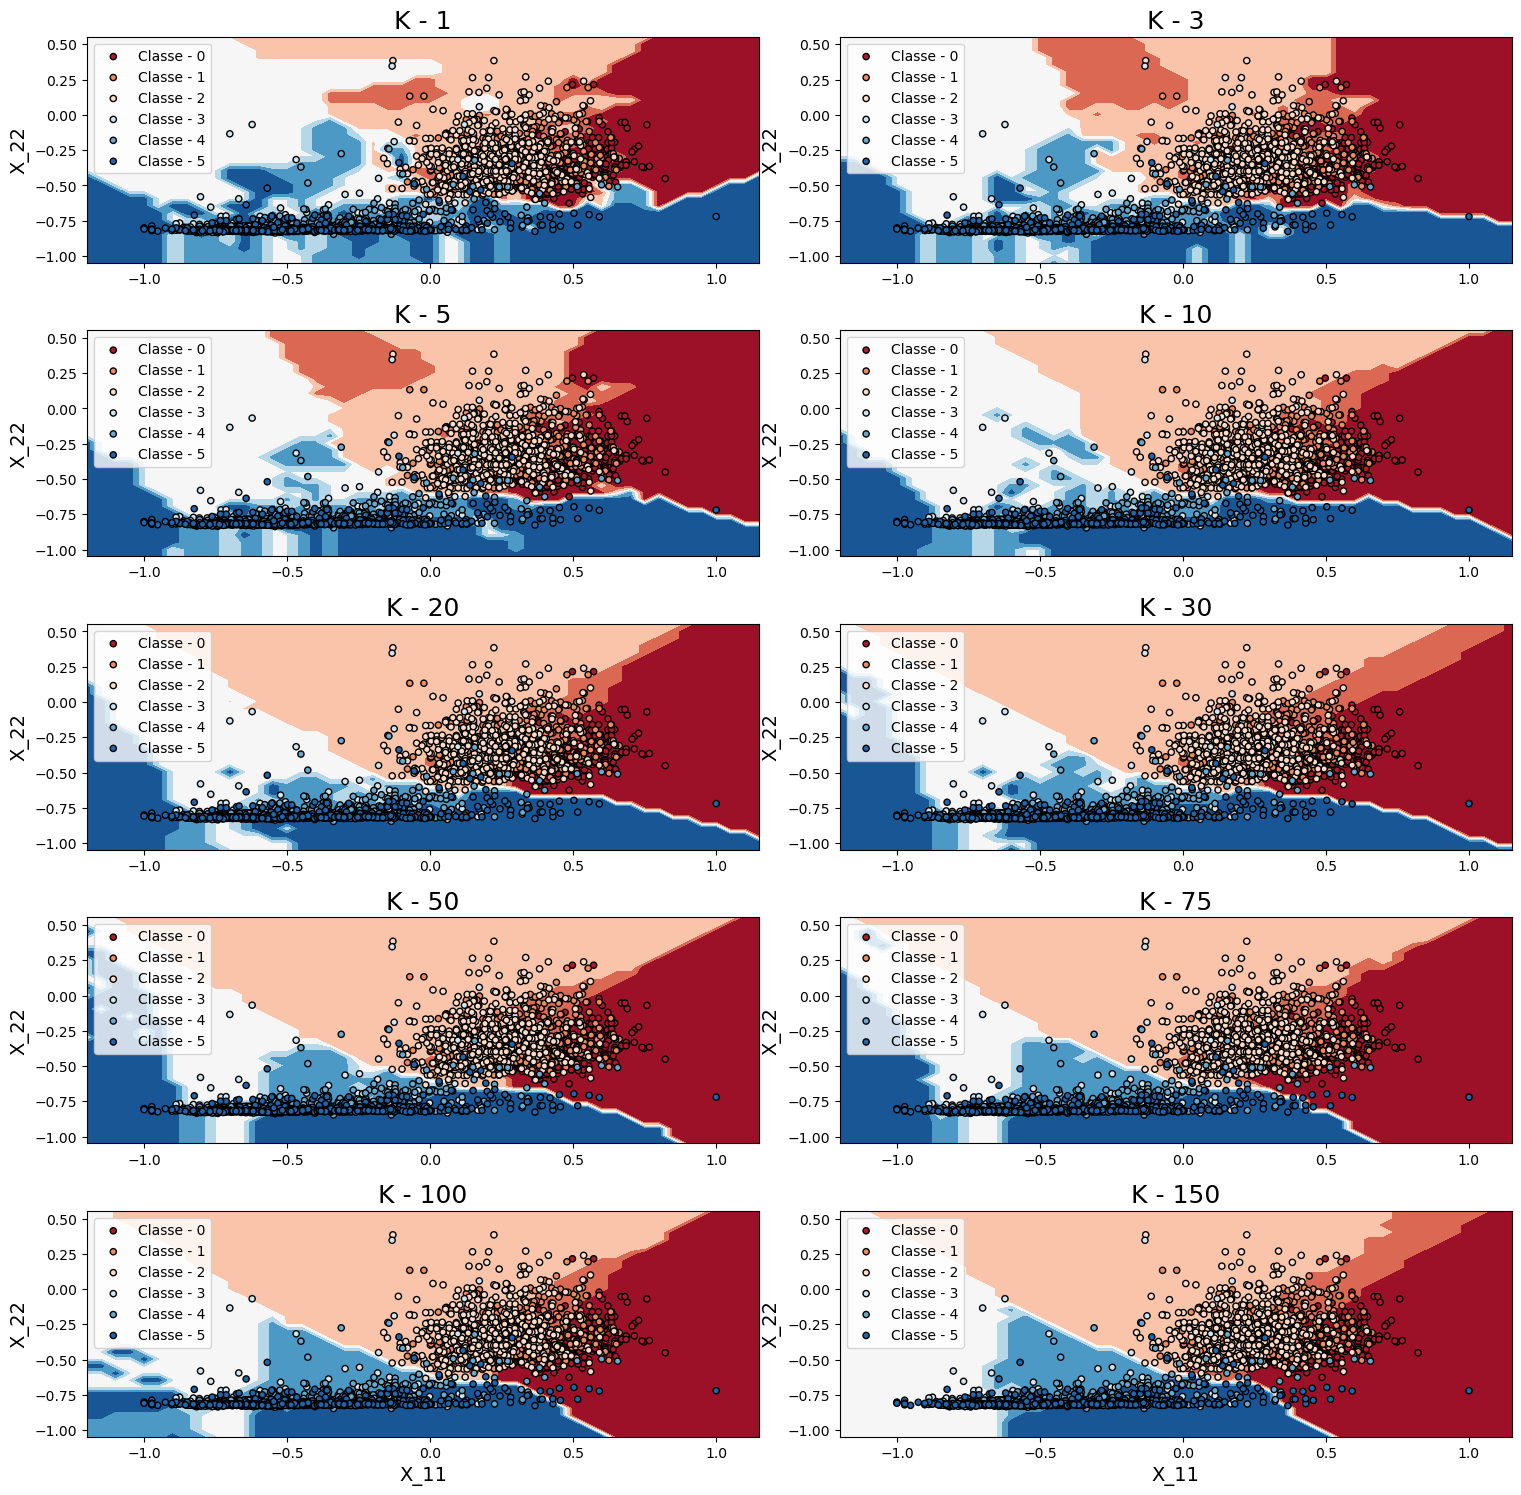

In [15]:
lista_label = [1,2,3,4,5,6]

colors =[ "#B2182B","#EF8A62","#FDDBC7","#D1E5F0","#67A9CF","#2166AC"]

new_list = []

for i in range(len(Y_test)):
    
    new_list.append(Y_test[i][0])


lista_colors=[]

for value in (lista_label):
    
    lista_indices = list(np.argwhere(Y_test==value)[:,0])
    
    for indice in lista_indices:
        
        new_list[indice] = colors[value-1]

final_Y_color=np.array(new_list)

column_A =22

column_B =11

x_min, x_max = X_test[:,column_A].min()-0.2, X_test[:,column_A].max()+0.2
y_min, y_max = X_test[:,column_B].min()-0.2, X_test[:,column_B].max()+0.2

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05), np.arange(y_min, y_max, 0.05))

ravel = np.c_[xx.ravel(), yy.ravel()]

figure, ax = plt.subplots(int(len(K_values)/2),2, figsize=(15,20))

plt.subplots_adjust(left=0.05, right=1, bottom=0.1, top=0.8, wspace=0.12, hspace=0.3)

for pos in range(len(K_values)):
    
    new_Z = np.zeros((ravel.shape[0],1))

    for i in range(ravel.shape[0]):

        new_Z [i, 0]= KNN (X_test[:,[column_A, column_B]], Y_test, ravel[i,:],K_values[pos])
    
    if pos%2 ==1:
        
        row, col = int((pos-1)/2), 1
        
    else:
        
        row, col = int(pos/2),0
        
        
    Z =new_Z.reshape(xx.shape)
    
    ax[row, col].contourf(xx, yy, Z, alpha=1, cmap='RdBu')
    
    ax[row,col].set_ylabel(f'X_{column_A}', fontsize=14);
    
    
    if pos == len(K_values)-1 or pos == len(K_values)-2:  
    
        ax[row,col].set_xlabel(f'X_{column_B}', fontsize=14);
        
    for value in (lista_label):
           
        ax[row, col].scatter(X_test[np.argwhere(Y_test==value)[:,0], column_A], X_test[np.argwhere(Y_test==value)[:,0], column_B], 
                             c=final_Y_color[final_Y_color==colors[value-1]], edgecolors = 'black' ,label=f'Classe - {value-1}',s=20)
    
    ax[row, col].legend()
    title = f'K - {K_values[pos]}'
    ax[row, col].set_title(title, fontsize=18)